In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12
sns.set_palette("husl")

print("All libraries imported successfully!")


All libraries imported successfully!


In [31]:
def generate_sales_data(n_records=5000):
    """
    Generate realistic sales data for analysis
    """
    np.random.seed(42)
    
    start_date = datetime(2020, 1, 1)
    dates = [start_date + timedelta(days=x) for x in range(n_records)]
    
    products = ['Laptop', 'Smartphone', 'Tablet', 'Headphones', 'Mouse', 'Keyboard', 'Monitor', 'Camera']
    categories = ['Electronics', 'Computers', 'Accessories']
    regions = ['Riyadh', 'Jeddah', 'Dammam', 'Mecca', 'Medina']
    sales_channels = ['Online Store', 'Physical Store', 'Mobile App']
    
    data = []
    
    for i, date in enumerate(dates):

        seasonal_factor = 1 + 0.3 * np.sin(2 * np.pi * date.timetuple().tm_yday / 365)
        weekend_factor = 1.2 if date.weekday() >= 5 else 1.0
        
        summer_factor = 0.8 if date.month in [6, 7, 8] else 1.0
        
        ramadan_factor = 1.4 if date.month in [4, 5] else 1.0
        
        n_transactions = np.random.poisson(10) + 1
        
        for _ in range(n_transactions):
            product = np.random.choice(products)
            category = np.random.choice(categories)
            region = np.random.choice(regions)
            channel = np.random.choice(sales_channels)
            
            base_prices = {
                'Laptop': 3000, 'Smartphone': 2000, 'Tablet': 1500,
                'Headphones': 300, 'Mouse': 100, 'Keyboard': 200,
                'Monitor': 800, 'Camera': 1200
            }
            
            base_price = base_prices.get(product, 500)
            price = base_price * np.random.uniform(0.8, 1.3)
            
            
            quantity = np.random.poisson(2) + 1
            
            sales = (price * quantity * seasonal_factor * weekend_factor * 
                    summer_factor * ramadan_factor * np.random.uniform(0.9, 1.1))
            
            marketing_cost = sales * np.random.uniform(0.05, 0.15)
            
            data.append({
                'date': date.strftime('%Y-%m-%d'),
                'product': product,
                'category': category,
                'region': region,
                'sales_channel': channel,
                'price': round(price, 2),
                'quantity': quantity,
                'total_sales': round(sales, 2),
                'marketing_cost': round(marketing_cost, 2),
                'day_of_week': date.strftime('%A'),
                'month': date.month,
                'year': date.year,
                'quarter': (date.month - 1) // 3 + 1
            })
    
    return pd.DataFrame(data)

print(" Generating sales data...")
df = generate_sales_data(5000)
print(f"Generated {len(df)} sales records")

print("\n Basic data information:")
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")
print(f"Date range: from {df['date'].min()} to {df['date'].max()}")

print("\n First 5 rows of data:")
print(df.head())


 Generating sales data...
Generated 55342 sales records

 Basic data information:
Number of rows: 55342
Number of columns: 13
Date range: from 2020-01-01 to 2033-09-08

 First 5 rows of data:
         date   product     category  region   sales_channel    price  \
0  2020-01-01   Monitor    Computers  Dammam      Mobile App   663.23   
1  2020-01-01  Keyboard    Computers   Mecca    Online Store   221.75   
2  2020-01-01   Monitor    Computers   Mecca      Mobile App   822.43   
3  2020-01-01    Tablet  Accessories  Medina    Online Store  1248.79   
4  2020-01-01   Monitor  Electronics  Dammam  Physical Store   796.42   

   quantity  total_sales  marketing_cost day_of_week  month  year  quarter  
0         4      2917.25          388.71   Wednesday      1  2020        1  
1         2       403.26           41.33   Wednesday      1  2020        1  
2         3      2525.86          138.03   Wednesday      1  2020        1  
3         5      6507.44          611.80   Wednesday      1  

In [32]:
df['date'] = pd.to_datetime(df['date'])

print("\n Detailed data information:")
print(df.info())

print("\n Descriptive statistics:")
print(df.describe())

print("\n Missing values:")
missing_values = df.isnull().sum()
missing_count = missing_values[missing_values > 0]
print(missing_count if len(missing_count) > 0 else " No missing values!")

duplicates = df.duplicated().sum()
print(f"\n Number of duplicate rows: {duplicates}")

df['day'] = df['date'].dt.day
df['week'] = df['date'].dt.isocalendar().week
df['is_weekend'] = df['date'].dt.weekday >= 5

print(" Data cleaned and new features added!")



 Detailed data information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55342 entries, 0 to 55341
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            55342 non-null  datetime64[ns]
 1   product         55342 non-null  object        
 2   category        55342 non-null  object        
 3   region          55342 non-null  object        
 4   sales_channel   55342 non-null  object        
 5   price           55342 non-null  float64       
 6   quantity        55342 non-null  int64         
 7   total_sales     55342 non-null  float64       
 8   marketing_cost  55342 non-null  float64       
 9   day_of_week     55342 non-null  object        
 10  month           55342 non-null  int64         
 11  year            55342 non-null  int64         
 12  quarter         55342 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(4), object(5)
memory usage: 5.5+ MB
N

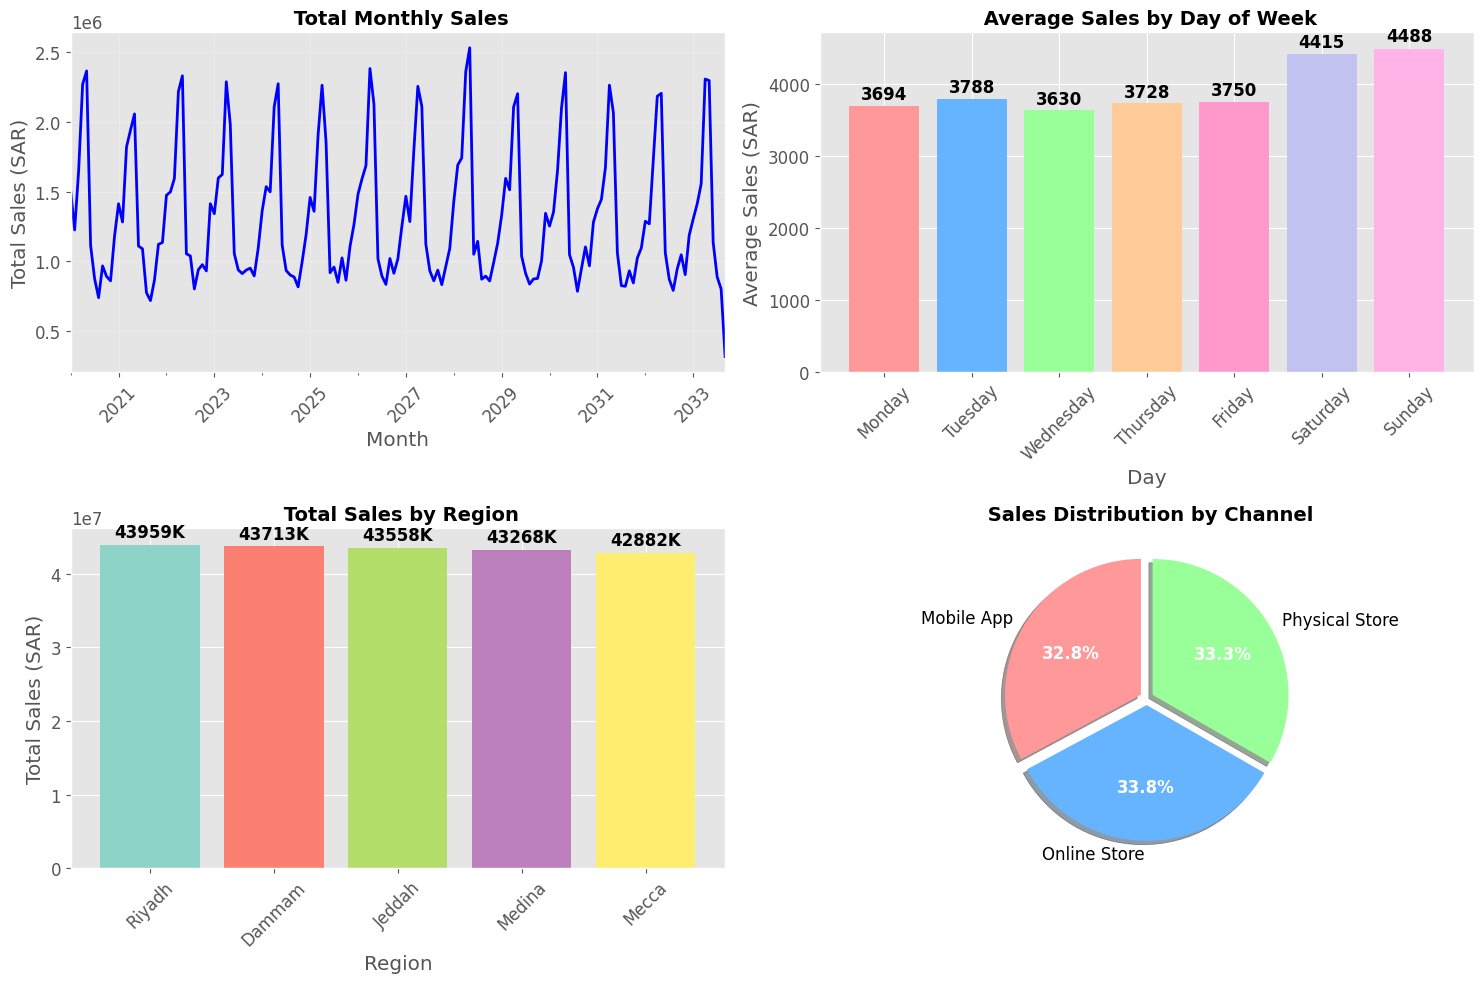

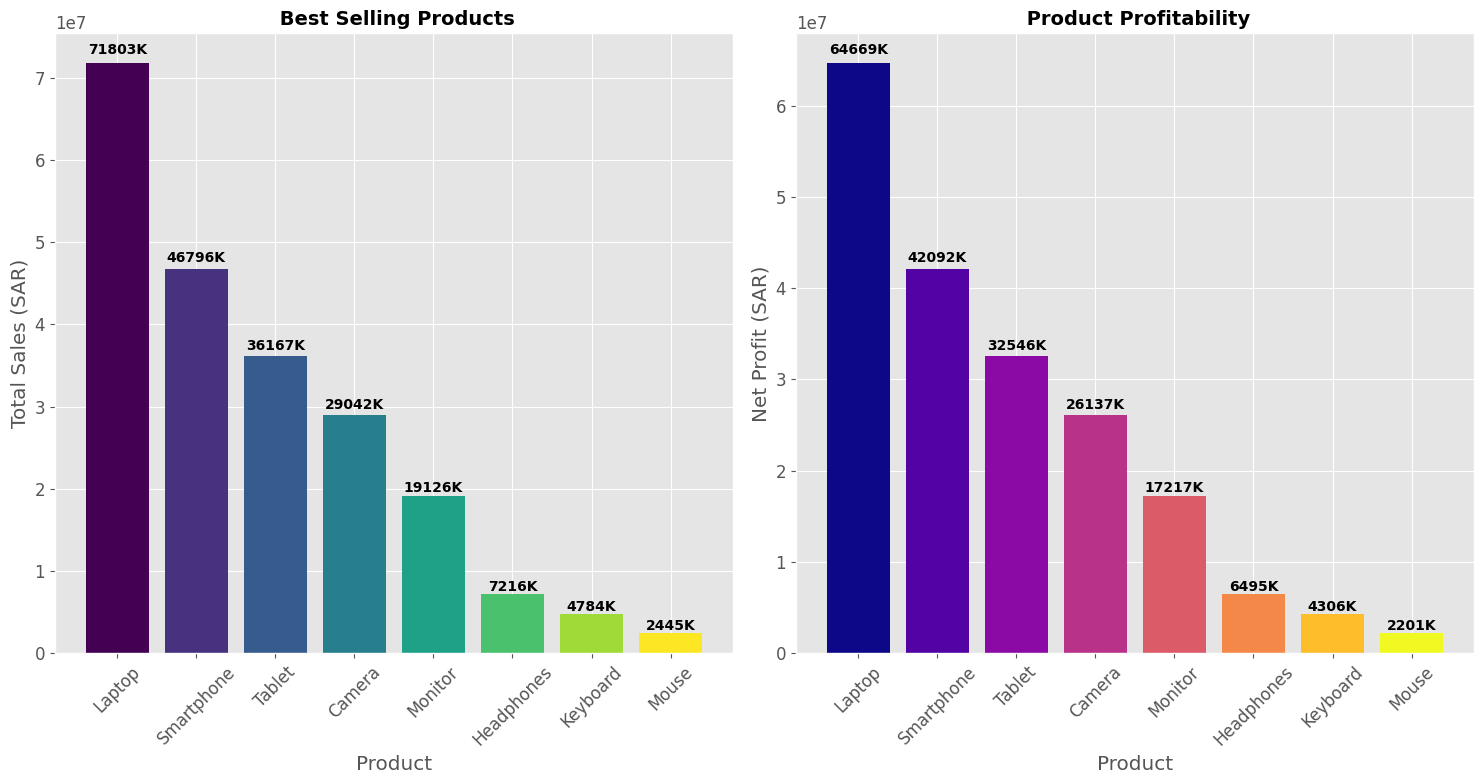

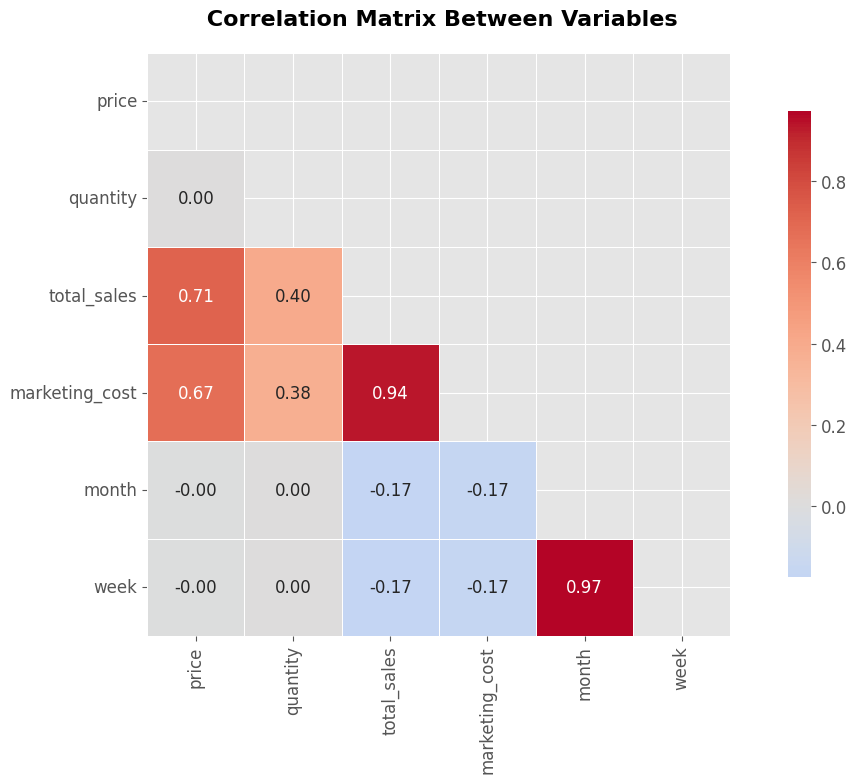

 Exploratory data analysis completed!


In [26]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
monthly_sales = df.groupby([df['date'].dt.to_period('M')])['total_sales'].sum()
monthly_sales.plot(kind='line', color='blue', linewidth=2)
plt.title(' Total Monthly Sales', fontsize=14, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Total Sales (SAR)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 2)
weekday_sales = df.groupby('day_of_week')['total_sales'].mean()
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_sales = weekday_sales.reindex(days_order)
bars = plt.bar(range(len(weekday_sales)), weekday_sales.values, 
               color=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#ff99cc', '#c2c2f0', '#ffb3e6'])
plt.title(' Average Sales by Day of Week', fontsize=14, fontweight='bold')
plt.xlabel('Day')
plt.ylabel('Average Sales (SAR)')
plt.xticks(range(len(days_order)), days_order, rotation=45)

for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{height:.0f}', ha='center', va='bottom', fontweight='bold')

plt.subplot(2, 2, 3)
region_sales = df.groupby('region')['total_sales'].sum().sort_values(ascending=False)
colors = plt.cm.Set3(np.linspace(0, 1, len(region_sales)))
bars = plt.bar(region_sales.index, region_sales.values, color=colors)
plt.title(' Total Sales by Region', fontsize=14, fontweight='bold')
plt.xlabel('Region')
plt.ylabel('Total Sales (SAR)')
plt.xticks(rotation=45)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{height/1000:.0f}K', ha='center', va='bottom', fontweight='bold')

plt.subplot(2, 2, 4)
channel_sales = df.groupby('sales_channel')['total_sales'].sum()
explode = (0.05, 0.05, 0.05)
colors = ['#ff9999', '#66b3ff', '#99ff99']
wedges, texts, autotexts = plt.pie(channel_sales.values, labels=channel_sales.index, 
                                  autopct='%1.1f%%', explode=explode, colors=colors,
                                  shadow=True, startangle=90)
plt.title(' Sales Distribution by Channel', fontsize=14, fontweight='bold')

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 8))

product_performance = df.groupby('product').agg({
    'total_sales': 'sum',
    'quantity': 'sum',
    'marketing_cost': 'sum'
}).sort_values('total_sales', ascending=False)

plt.subplot(1, 2, 1)
bars = plt.bar(product_performance.index, product_performance['total_sales'], 
               color=plt.cm.viridis(np.linspace(0, 1, len(product_performance))))
plt.title(' Best Selling Products', fontsize=14, fontweight='bold')
plt.xlabel('Product')
plt.ylabel('Total Sales (SAR)')
plt.xticks(rotation=45)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{height/1000:.0f}K', ha='center', va='bottom', fontweight='bold', fontsize=10)

product_performance['profit'] = product_performance['total_sales'] - product_performance['marketing_cost']

plt.subplot(1, 2, 2)
profit_bars = plt.bar(product_performance.index, product_performance['profit'], 
                     color=plt.cm.plasma(np.linspace(0, 1, len(product_performance))))
plt.title(' Product Profitability', fontsize=14, fontweight='bold')
plt.xlabel('Product')
plt.ylabel('Net Profit (SAR)')
plt.xticks(rotation=45)

for bar in profit_bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{height/1000:.0f}K', ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
numeric_columns = ['price', 'quantity', 'total_sales', 'marketing_cost', 'month', 'week']
correlation_matrix = df[numeric_columns].corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8}, fmt='.2f')
plt.title(' Correlation Matrix Between Variables', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print(" Exploratory data analysis completed!")


In [33]:
print("\n Preparing data for modeling...")

df_model = df.copy()

label_encoders = {}
categorical_columns = ['product', 'category', 'region', 'sales_channel', 'day_of_week']

for col in categorical_columns:
    le = LabelEncoder()
    df_model[f'{col}_encoded'] = le.fit_transform(df_model[col])
    label_encoders[col] = le

df_model['weekend_flag'] = df_model['is_weekend'].astype(int)

feature_columns = [
    'price', 'quantity', 'marketing_cost', 'month', 'day', 'week', 'quarter',
    'product_encoded', 'category_encoded', 'region_encoded', 'sales_channel_encoded',
    'day_of_week_encoded', 'weekend_flag'
]

X = df_model[feature_columns]
y = df_model['total_sales']

print(f" Data shape: {X.shape}")
print(f" Features used: {len(feature_columns)}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f" Training data: {X_train.shape}")
print(f" Testing data: {X_test.shape}")



 Preparing data for modeling...
 Data shape: (55342, 13)
 Features used: 13
 Training data: (44273, 13)
 Testing data: (11069, 13)


In [34]:
print("\n Building and training models...")

models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

model_results = {}

for name, model in models.items():
    print(f"\n Training model: {name}")
    
    if name == 'Linear Regression':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    
    model_results[name] = {
        'model': model,
        'predictions': y_pred,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2,
        'MAPE': mape
    }
    
    print(f"    Mean Absolute Error (MAE): {mae:.2f}")
    print(f"    Root Mean Square Error (RMSE): {rmse:.2f}")
    print(f"    R-squared (R²): {r2:.4f}")
    print(f"    Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

print("\n All models trained successfully!")



 Building and training models...

 Training model: Linear Regression
    Mean Absolute Error (MAE): 882.17
    Root Mean Square Error (RMSE): 1469.55
    R-squared (R²): 0.9022
    Mean Absolute Percentage Error (MAPE): 63.65%

 Training model: Random Forest
    Mean Absolute Error (MAE): 315.23
    Root Mean Square Error (RMSE): 750.74
    R-squared (R²): 0.9745
    Mean Absolute Percentage Error (MAPE): 7.45%

 Training model: Gradient Boosting
    Mean Absolute Error (MAE): 589.33
    Root Mean Square Error (RMSE): 1023.10
    R-squared (R²): 0.9526
    Mean Absolute Percentage Error (MAPE): 21.99%

 All models trained successfully!



 Comparing model performance...

 Model Comparison Table:
               Model       MAE       RMSE      R²   MAPE %
0  Linear Regression  882.1657  1469.5470  0.9022  63.6486
1      Random Forest  315.2284   750.7406  0.9745   7.4512
2  Gradient Boosting  589.3295  1023.0951  0.9526  21.9901

 Best Model: Random Forest
   R² = 0.9745


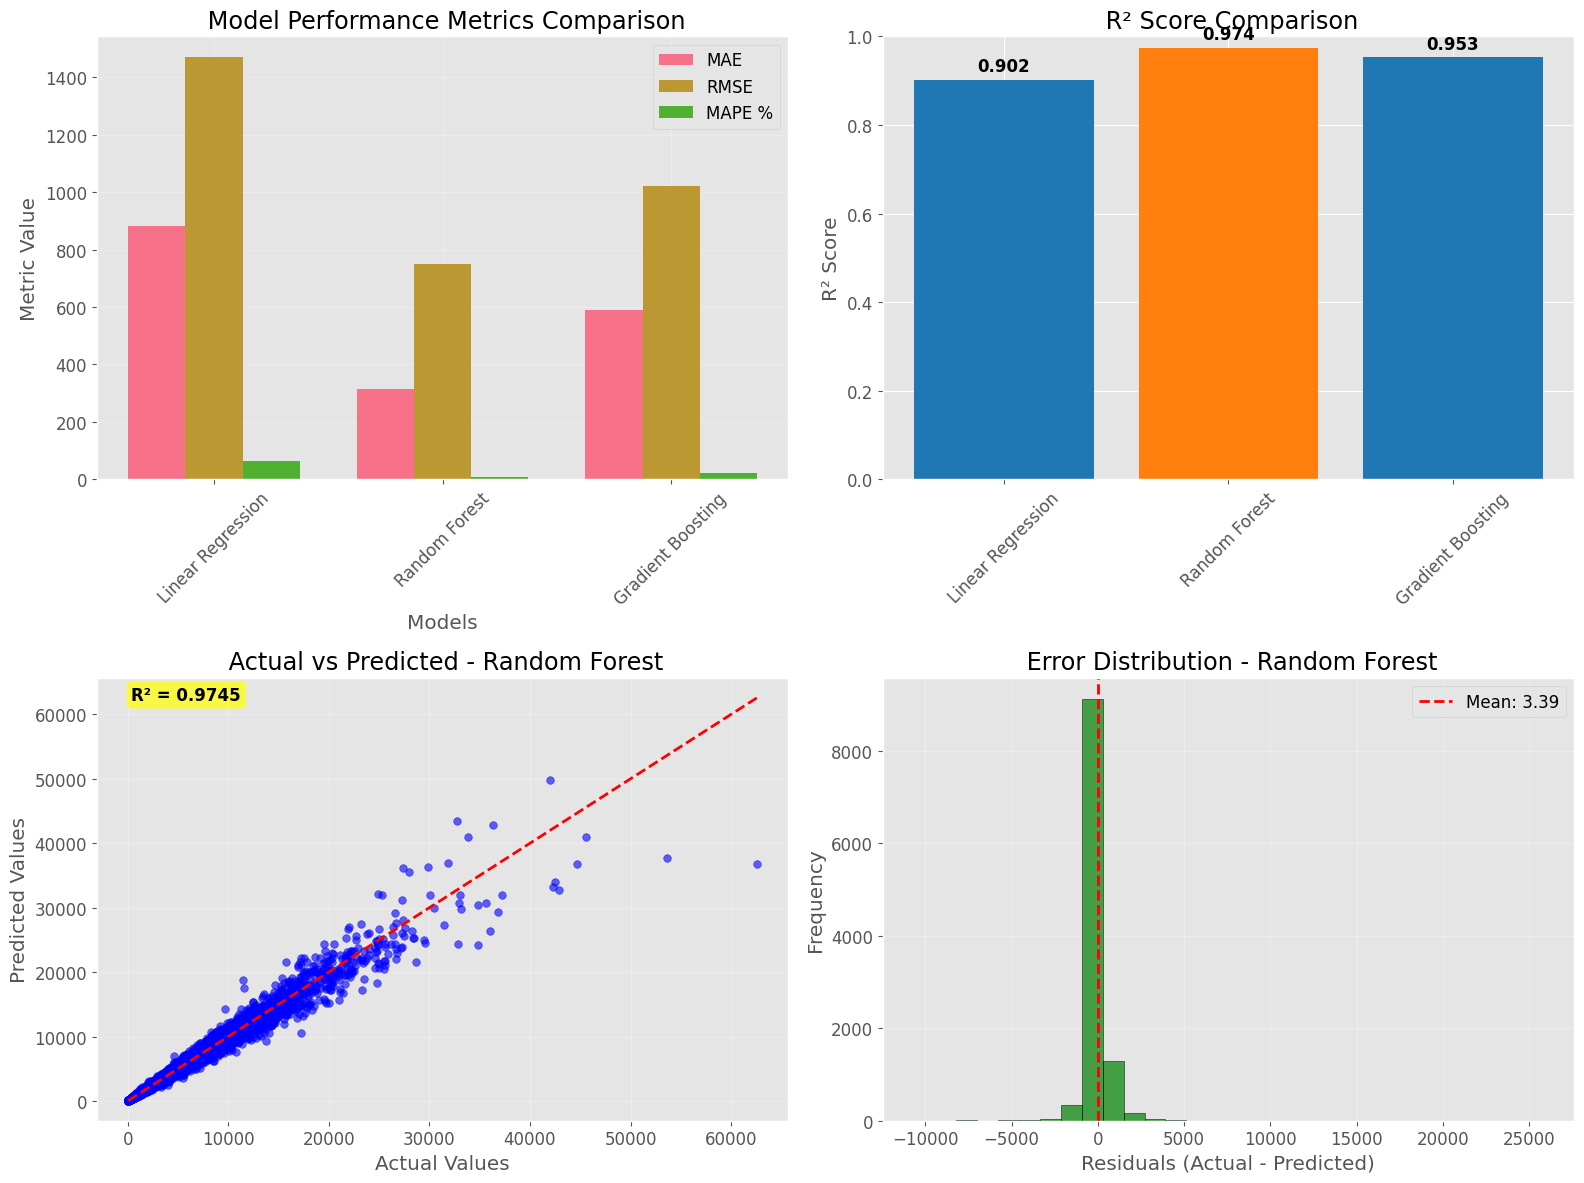

In [35]:
print("\n Comparing model performance...")

comparison_df = pd.DataFrame({
    'Model': list(model_results.keys()),
    'MAE': [results['MAE'] for results in model_results.values()],
    'RMSE': [results['RMSE'] for results in model_results.values()],
    'R²': [results['R2'] for results in model_results.values()],
    'MAPE %': [results['MAPE'] for results in model_results.values()]
})

print("\n Model Comparison Table:")
print(comparison_df.round(4))

best_model_name = comparison_df.loc[comparison_df['R²'].idxmax(), 'Model']
best_model = model_results[best_model_name]['model']
best_predictions = model_results[best_model_name]['predictions']

print(f"\n Best Model: {best_model_name}")
print(f"   R² = {model_results[best_model_name]['R2']:.4f}")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

ax1 = axes[0, 0]
metrics = ['MAE', 'RMSE', 'MAPE %']
x = np.arange(len(model_results))
width = 0.25

for i, metric in enumerate(metrics):
    values = [model_results[model][metric] if metric != 'MAPE %' else model_results[model]['MAPE'] 
             for model in model_results.keys()]
    ax1.bar(x + i*width, values, width, label=metric)

ax1.set_xlabel('Models')
ax1.set_ylabel('Metric Value')
ax1.set_title(' Model Performance Metrics Comparison')
ax1.set_xticks(x + width)
ax1.set_xticklabels(model_results.keys(), rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2 = axes[0, 1]
r2_scores = [model_results[model]['R2'] for model in model_results.keys()]
colors = ['#ff7f0e' if name == best_model_name else '#1f77b4' for name in model_results.keys()]
bars = ax2.bar(model_results.keys(), r2_scores, color=colors)
ax2.set_ylabel('R² Score')
ax2.set_title(' R² Score Comparison')
ax2.set_ylim(0, 1)
plt.setp(ax2.get_xticklabels(), rotation=45)

for bar, score in zip(bars, r2_scores):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

ax3 = axes[1, 0]
ax3.scatter(y_test, best_predictions, alpha=0.6, color='blue', s=30)
min_val = min(y_test.min(), best_predictions.min())
max_val = max(y_test.max(), best_predictions.max())
ax3.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
ax3.set_xlabel('Actual Values')
ax3.set_ylabel('Predicted Values')
ax3.set_title(f' Actual vs Predicted - {best_model_name}')
ax3.grid(True, alpha=0.3)

ax3.text(0.05, 0.95, f'R² = {model_results[best_model_name]["R2"]:.4f}', 
         transform=ax3.transAxes, fontsize=12, fontweight='bold',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

ax4 = axes[1, 1]
residuals = y_test - best_predictions
ax4.hist(residuals, bins=30, alpha=0.7, color='green', edgecolor='black')
ax4.axvline(residuals.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {residuals.mean():.2f}')
ax4.set_xlabel('Residuals (Actual - Predicted)')
ax4.set_ylabel('Frequency')
ax4.set_title(f' Error Distribution - {best_model_name}')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


 Feature importance analysis...

 Most important features affecting sales:
                Feature  Importance
2        marketing_cost    0.888940
0                 price    0.033940
1              quantity    0.032990
5                  week    0.016744
3                 month    0.011659
12         weekend_flag    0.003580
4                   day    0.003440
6               quarter    0.002942
11  day_of_week_encoded    0.001834
9        region_encoded    0.001499


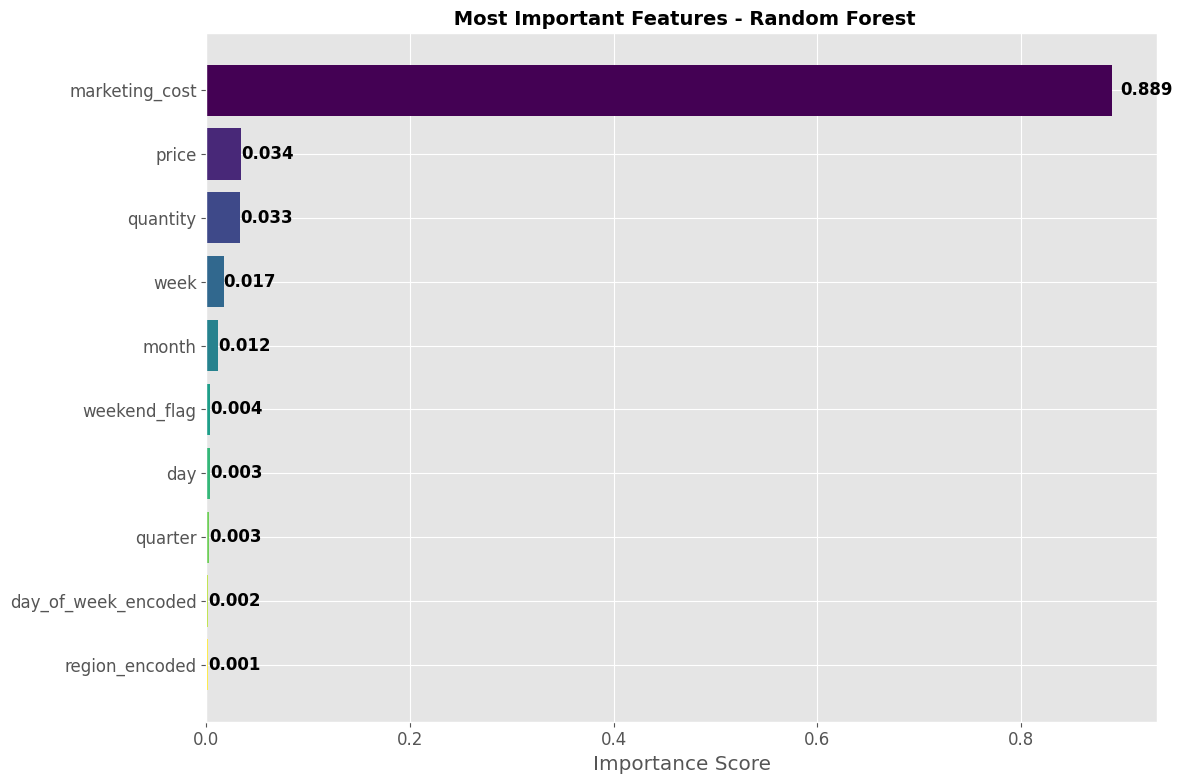

In [36]:
print("\n Feature importance analysis...")

if best_model_name != 'Linear Regression':
    feature_importance = pd.DataFrame({
        'Feature': feature_columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\n Most important features affecting sales:")
    print(feature_importance.head(10))
    
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(10)
    colors = plt.cm.viridis(np.linspace(0, 1, len(top_features)))
    bars = plt.barh(range(len(top_features)), top_features['Importance'], color=colors)
    plt.yticks(range(len(top_features)), top_features['Feature'])
    plt.xlabel('Importance Score')
    plt.title(f' Most Important Features - {best_model_name}', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width + width*0.01, bar.get_y() + bar.get_height()/2,
                 f'{width:.3f}', ha='left', va='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

else:
    print(" Linear Regression doesn't provide direct feature importance measure")


In [37]:
print("\n BUSINESS INSIGHTS & RECOMMENDATIONS")
print("=" * 50)

print("\n TOP PERFORMING PRODUCTS:")
top_products = df.groupby('product')['total_sales'].sum().sort_values(ascending=False).head(3)
for i, (product, sales) in enumerate(top_products.items(), 1):
    print(f"{i}. {product}: {sales:,.2f} SAR")

print("\n BEST PERFORMING REGIONS:")
top_regions = df.groupby('region')['total_sales'].sum().sort_values(ascending=False).head(3)
for i, (region, sales) in enumerate(top_regions.items(), 1):
    print(f"{i}. {region}: {sales:,.2f} SAR")

print("\n SALES CHANNEL PERFORMANCE:")
channel_performance = df.groupby('sales_channel')['total_sales'].sum().sort_values(ascending=False)
for channel, sales in channel_performance.items():
    percentage = (sales / channel_performance.sum()) * 100
    print(f"• {channel}: {sales:,.2f} SAR ({percentage:.1f}%)")

print("\n SEASONAL INSIGHTS:")
monthly_avg = df.groupby('month')['total_sales'].mean()
best_month = monthly_avg.idxmax()
worst_month = monthly_avg.idxmin()
print(f"• Best performing month: {best_month} (Avg: {monthly_avg[best_month]:,.2f} SAR)")
print(f"• Lowest performing month: {worst_month} (Avg: {monthly_avg[worst_month]:,.2f} SAR)")

weekend_sales = df[df['is_weekend']]['total_sales'].mean()
weekday_sales = df[~df['is_weekend']]['total_sales'].mean()
print(f"\n WEEKEND vs WEEKDAY:")
print(f"• Weekend average: {weekend_sales:.2f} SAR")
print(f"• Weekday average: {weekday_sales:.2f} SAR")
print(f"• Weekend premium: {((weekend_sales/weekday_sales - 1) * 100):+.1f}%")



 BUSINESS INSIGHTS & RECOMMENDATIONS

 TOP PERFORMING PRODUCTS:
1. Laptop: 71,802,767.59 SAR
2. Smartphone: 46,796,388.76 SAR
3. Tablet: 36,167,200.09 SAR

 BEST PERFORMING REGIONS:
1. Riyadh: 43,959,101.54 SAR
2. Dammam: 43,713,203.51 SAR
3. Jeddah: 43,558,250.21 SAR

 SALES CHANNEL PERFORMANCE:
• Online Store: 73,545,253.04 SAR (33.8%)
• Physical Store: 72,432,942.60 SAR (33.3%)
• Mobile App: 71,401,846.96 SAR (32.8%)

 SEASONAL INSIGHTS:
• Best performing month: 4 (Avg: 6,677.20 SAR)
• Lowest performing month: 8 (Avg: 2,390.28 SAR)

 WEEKEND vs WEEKDAY:
• Weekend average: 4450.69 SAR
• Weekday average: 3718.15 SAR
• Weekend premium: +19.7%
